#  **WeedsAI** - HIVE Project LiveAI
Transforming Farmers lives with Intelligent AI

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Hive_Agri')

In [3]:
import tensorflow_datasets as tfds
import logging
from zipfile import ZipFile
import os
import shutil
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from utils.events import download_google_drive_file
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [4]:
"""Global Variables"""

IMG_DIRECTORY = "./images/"
IMG_GD_ID = "1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj" # Check https://www.tensorflow.org/datasets/catalog/deep_weeds or https://github.com/AlexOlsen/DeepWeeds
IMG_ZIP_FILE = "./images/images.zip"
LABELS_URL = 'https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv'
IMG_H = 224
IMG_W = 224
IMG_SHAPE = (IMG_H,IMG_W, 3)
RDM_STATE = 43
CLASSES = ['Chinee apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed', 'Negative']

In [5]:
'''  Helper functions to download the dataset, make sure your notebook has access to utils.py '''

def download_dataset():
    if os.path.exists(IMG_DIRECTORY):
        logging.info("Found datasets folder, deleting..")
        shutil.rmtree(IMG_DIRECTORY)
    os.makedirs(IMG_DIRECTORY)
    logging.info("created image directory")
    download_google_drive_file(IMG_GD_ID, IMG_ZIP_FILE)
    logging.info("downloaded dataset from Google Drive")
    with ZipFile(IMG_ZIP_FILE,'r') as zip_ref:
        zip_ref.extractall(IMG_DIRECTORY)
        logging.info("Extracted .zip file")
        

def clear_zip():
    os.remove(IMG_ZIP_FILE)
    logging.info("Deleted .zip file")

In [6]:
"""Run only if you wnat to download the dataset. Code will be commented for precaution"""
download_dataset()
clear_zip()

<h1> Exploratory Analysis </h1>

Let's start by taking a look at the dataset




Negative          9106
Chinee apple      1125
Siam weed         1074
Lantana           1064
Prickly acacia    1062
Parkinsonia       1031
Parthenium        1022
Snake weed        1016
Rubber vine       1009
Name: Species, dtype: int64
17509


,Filename,Label,Species
2109,20170705-165213-0.jpg,7,Snake weed
9113,20171205-133603-2.jpg,8,Negative
10782,20171219-113951-3.jpg,8,Negative
6956,20171109-070713-3.jpg,5,Rubber vine


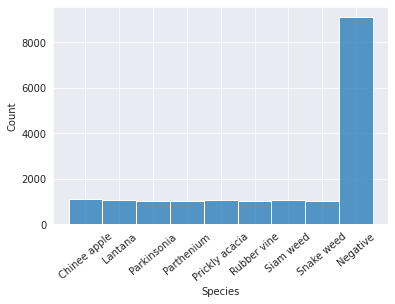

In [7]:
# Get the labels for the images
df = pd.read_csv(LABELS_URL)
print(df['Species'].value_counts())
print(len(df))
df.sort_values(by ='Label',inplace=True)
sns.set_style("darkgrid")
sns.histplot(df, x='Species')
plt.xticks(rotation=40)
df.sample(4)

,Filename,Label,Species,Weed
2377,20170714-112930-2.jpg,1,Lantana,1
13562,20180109-103423-1.jpg,8,Negative,0
4608,20170906-110802-4.jpg,3,Parthenium,1
16541,20180125-134424-3.jpg,8,Negative,0


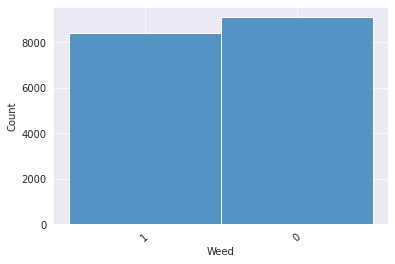

In [8]:
df['Weed'] = df['Species'] != 'Negative'
df['Weed'] = df['Weed'].astype(int).astype(str)
sns.histplot(df, x='Weed')
plt.xticks(rotation=40)
df.sample(4)

We clearly have an imbalanced dataset. There are several ways to tackle this:

+ Undersampling, oversampling, SMOTE -> No improvements using these. The model started to overfit a bit. SMOTE was not used
+ Getting more data -> No public data was found/
+ First tackle as a binary classification problem (Weed, not Weed) and then later classified in each species -> This was only tried in the early stages of the model without showing any improvement as tackling the problem as a multiclass one
+ Using class weights: The model learns more from the minority classes than from the majority ones -> This was the method that provided more improvements from all, especially by looking at the confusion matrix.


In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(df['Label']), df['Label'])
print(np.unique(df['Label']))
print(class_weights)
print('Note the labels, after the image genertor this might change')

[0 1 2 3 4 5 6 7 8]
[1.72928395 1.82842523 1.88694902 1.90356599 1.83186859 1.92809162
 1.81140079 1.91480752 0.21364424]
Note the labels, after the image genertor this might change


Lets take a look at random images from each class

In [10]:
def rdm_img_each_class():
    '''Shows a random image of each class '''
    _, ax = plt.subplots(1, 9, figsize = (30, 15))
    for j in range(9):
        df_label_j = df[df['Label'] == j]
        sample = df_label_j.sample()
        img_name = sample['Filename'].iloc[0]
        img_species = sample['Species'].iloc[0]
        path = os.path.join(IMG_DIRECTORY, img_name)
        img = plt.imread(path)
        ax[j].imshow(img)
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(img_species)
    return None

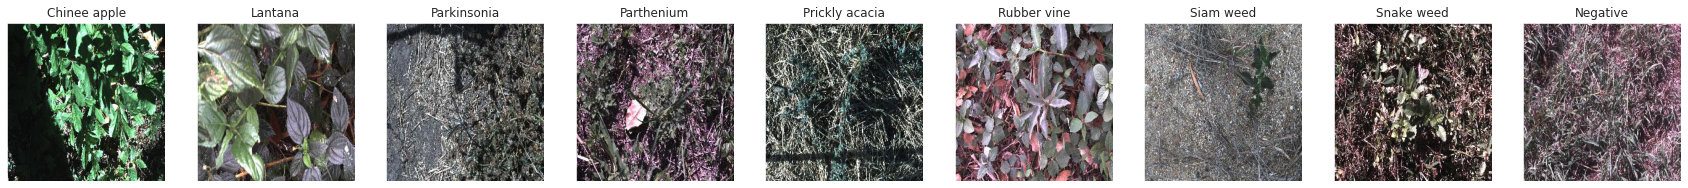

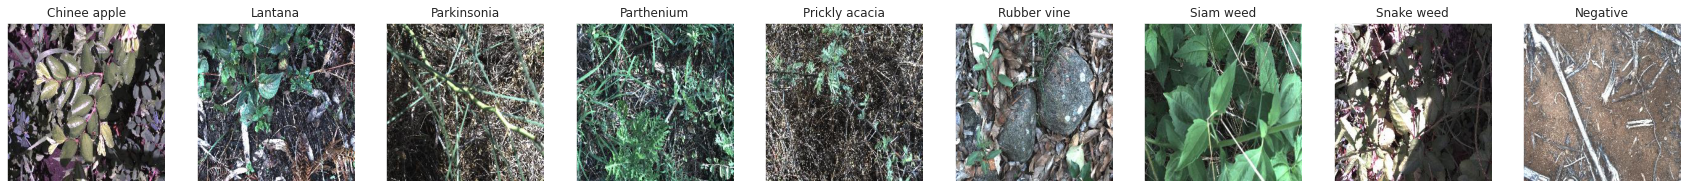

In [11]:
rdm_img_each_class()
rdm_img_each_class()

In [12]:
# Are all images same dimension?
def get_dim_for_all_images():
    """This function gets dimentions of all images     
    Returns: list of Heights, Widths and Channels for each image present in the folder
    """
    img_list = os.listdir(IMG_DIRECTORY)
    h_list = []
    w_list = []
    c_list = []
    for item in img_list:
          img = plt.imread(os.path.join(IMG_DIRECTORY, item))
          h_list.append(img.shape[0])
          w_list.append(img.shape[1])
          c_list.append(img.shape[2])
    return h_list, w_list, c_list


In [13]:
#dim1, dim2, colors = get_dim_for_all_images()
#print(np.mean(dim1), np.mean(dim2), np.mean(colors))
#sns.jointplot(dim1, dim2) 

<h1> Image Augmentation </h1>

First, split our dataset into training validation and test


In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state= RDM_STATE, stratify=df['Label'])
train, validation = train_test_split(train, test_size=0.25, random_state= RDM_STATE, stratify=train['Label'])
print(' We have a split of 60%, 20%, 20% for train, validation and test data: ',len(train), len(validation), len(test))

 We have a split of 60%, 20%, 20% for train, validation and test data:  10505 3502 3502


In [15]:
from keras.applications.resnet50 import preprocess_input

train_img_generator = ImageDataGenerator(
    #rescale= 1 , #.0 / 255, 
    rotation_range = 360,
    width_shift_range=  0.3,
    shear_range= 0.2, 
    zoom_range= [0.6, 1], 
    horizontal_flip= True, 
    fill_mode= 'reflect', 
    #channel_shift_range=20,
    brightness_range=[0.6,1.2],
    preprocessing_function = preprocess_input  # This preprocess function is applied after all the augmentation and prepares data as it was prepared on the Resnet50 paper
    )

validation_img_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_img_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [17]:
train_image_gen = train_img_generator.flow_from_dataframe(train, directory=IMG_DIRECTORY, x_col='Filename', y_col='Species', target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=True, seed=RDM_STATE)
val_image_gen = validation_img_generator.flow_from_dataframe(validation, directory=IMG_DIRECTORY, x_col='Filename', y_col='Species', target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=True, seed=RDM_STATE)
test_image_gen = test_img_generator.flow_from_dataframe(test, directory=IMG_DIRECTORY, x_col='Filename', y_col='Species', target_size=(224, 224), class_mode='categorical', batch_size=32, shuffle=False, seed=RDM_STATE)

Found 10505 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.


In [18]:
class2num = train_image_gen.class_indices
num2class = {value : key for (key, value) in class2num.items()}
class2num

{'Chinee apple': 0,
 'Lantana': 1,
 'Negative': 2,
 'Parkinsonia': 3,
 'Parthenium': 4,
 'Prickly acacia': 5,
 'Rubber vine': 6,
 'Siam weed': 7,
 'Snake weed': 8}

Now we create a dictionary with the class weight obtained earlier.

In [19]:
class_weights_dic = {0:1.72928395 , 1:1.82842523 , 2:0.21364424 , 3:1.88694902, 4:1.90356599, 5:1.83186859, 6:1.92809162, 7:1.81140079, 8:1.91480752 }

In [20]:
def rdm_img_from_gen():
    '''Shows a random image from the augmented data '''
    _, ax = plt.subplots(1, 9, figsize = (30, 15))
    for j in range(9):
        batch_gen=next(train_image_gen)  # returns the next batch of images and labels 
        # batch[0] is the images, batch[1] are the labels
        img=batch_gen[0][j]   # this is the first image  batch[0][1] would be the next image
        ax[j].imshow(img.astype(np.uint8))   
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(num2class[np.argmax(batch_gen[1][j])])
    return None

The reason for the coloring of the image is that the preprocessing function of ResNet50 subtracts the mean value of the image and rescales it.

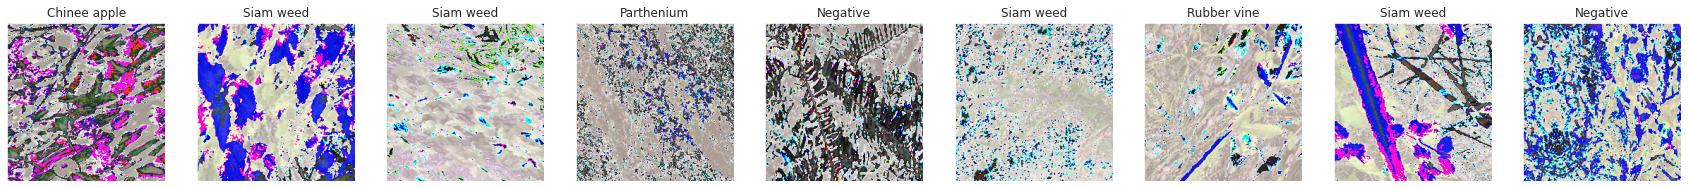

In [22]:
# Check images from the generator
rdm_img_from_gen()

<h1> Model </h1>

We will use transfer learning.

We start from a ResNet50 model and build a few new layers on top to adjust to our dataset.

We will also train a few of the last layers from the ResNet50.


We start by defining a few callbacks
Early stopping, Model chekcpoint, ReduceLR

In [23]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=11, verbose=1, restore_best_weights=True)
model_cp = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Hive_Agri/Weeds_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True ,save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

Importing the Resnet50 model and selecting training layers

In [24]:
from tensorflow.keras.applications import ResNet50
pretrained_model=ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

for layer in pretrained_model.layers[:-32]:  # The number of layer from the resnet model that are trained is a hyperparameter. 
                                             # Choosing to train some layers form resnet had improvements in accuracy 
     layer.trainable = False                 # With 32 we are training the whole last conv block


94773248/94765736 [==============================] - 1s 0us/step


In [25]:
# Add layers to pretrained model
tl_model = tf.keras.models.Sequential()
tl_model.add(pretrained_model)
tl_model.add(tf.keras.layers.GlobalAveragePooling2D())
#tl_model.add(tf.keras.layers.Dense(1024, activation='relu'))
tl_model.add(tf.keras.layers.Dense(512, activation='relu'))
tl_model.add(tf.keras.layers.Dropout(0.1))
tl_model.add(tf.keras.layers.Dense(9, activation='softmax'))


In [26]:
tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 24,641,417
Trainable params: 16,029,705
Non-trainable params: 8,611,712
_________________________________________________________________


In [27]:
opt=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
tl_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Training
Training for high number of epochs

In [28]:
tl_history1 = tl_model.fit(train_image_gen, epochs= 35, validation_data= val_image_gen, class_weight=class_weights_dic, shuffle=True, verbose=1, callbacks= [early_stopping, model_cp, reduce_lr])

Epoch 1/35
329/329 [==============================] - ETA: 0s - loss: 0.8533 - accuracy: 0.6314
Epoch 00001: val_accuracy improved from -inf to 0.68218, saving model to /content/drive/My Drive/Hive_Agri/Weeds_model.h5
329/329 [==============================] - 173s 527ms/step - loss: 0.8533 - accuracy: 0.6314 - val_loss: 1.0019 - val_accuracy: 0.6822
Epoch 2/35
329/329 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.7691
Epoch 00002: val_accuracy improved from 0.68218 to 0.76499, saving model to /content/drive/My Drive/Hive_Agri/Weeds_model.h5
329/329 [==============================] - 171s 518ms/step - loss: 0.4881 - accuracy: 0.7691 - val_loss: 0.7247 - val_accuracy: 0.7650
Epoch 3/35
329/329 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8069
Epoch 00003: val_accuracy improved from 0.76499 to 0.80069, saving model to /content/drive/My Drive/Hive_Agri/Weeds_model.h5
329/329 [==============================] - 170s 517ms/step - loss: 0.4

Save history to df and train for a few more epochs.

Note that since there was no earlystopping (the mode jsut reached the final epoch) the current weights are not the one that gave the highest accuracy. To get them we can load the weights form the checkpoint. We will train for a few more epochs

In [29]:
 pd.DataFrame.from_dict(tl_history1.history).to_csv('/content/drive/My Drive/Hive_Agri/weeds_history1.csv',index=False)

In [38]:
opt=tf.keras.optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
tl_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
tl_history2 = tl_model.fit(train_image_gen, epochs= 10, validation_data= val_image_gen, class_weight=class_weights_dic, shuffle=True, verbose=1, callbacks= [early_stopping, model_cp, reduce_lr])

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9628
Epoch 00001: val_accuracy did not improve from 0.90320
329/329 [==============================] - 172s 521ms/step - loss: 0.0568 - accuracy: 0.9628 - val_loss: 0.4019 - val_accuracy: 0.8869
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9670
Epoch 00002: val_accuracy did not improve from 0.90320
329/329 [==============================] - 164s 500ms/step - loss: 0.0593 - accuracy: 0.9670 - val_loss: 0.4009 - val_accuracy: 0.8918
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9676
Epoch 00003: val_accuracy improved from 0.90320 to 0.90662, saving model to /content/drive/My Drive/Hive_Agri/Weeds_model.h5
329/329 [==============================] - 163s 496ms/step - loss: 0.0495 - accuracy: 0.9676 - val_loss: 0.3702 - val_accuracy: 0.9066
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 0.

In [40]:
 pd.DataFrame.from_dict(tl_history2.history).to_csv('/content/drive/My Drive/Hive_Agri/weeds_history2.csv',index=False)

Save history. Now we will freeze all layers from the resnet model and only conitnue to train the added layers.

In [44]:
for layer in tl_model.layers:
     if layer.name =='resnet50': 
        layer.trainable = False

In [46]:
for layer in tl_model.layers:
  print(layer.trainable)

False
True
True
True
True


In [47]:
opt=tf.keras.optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
tl_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
tl_history3 = tl_model.fit(train_image_gen, epochs= 15, validation_data= val_image_gen, class_weight=class_weights_dic, shuffle=True, verbose=1, callbacks= [early_stopping, model_cp, reduce_lr])

Epoch 1/15
329/329 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9789
Epoch 00001: val_accuracy did not improve from 0.91576
329/329 [==============================] - 167s 507ms/step - loss: 0.0317 - accuracy: 0.9789 - val_loss: 0.3366 - val_accuracy: 0.9095
Epoch 2/15
329/329 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9813
Epoch 00002: val_accuracy did not improve from 0.91576
329/329 [==============================] - 164s 497ms/step - loss: 0.0263 - accuracy: 0.9813 - val_loss: 0.3448 - val_accuracy: 0.9121
Epoch 3/15
329/329 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9806
Epoch 00003: val_accuracy improved from 0.91576 to 0.91633, saving model to /content/drive/My Drive/Hive_Agri/Weeds_model.h5
329/329 [==============================] - 162s 492ms/step - loss: 0.0266 - accuracy: 0.9806 - val_loss: 0.3284 - val_accuracy: 0.9163
Epoch 4/15
329/329 [==============================] - ETA: 0s - loss: 0.

In [49]:
 pd.DataFrame.from_dict(tl_history3.history).to_csv('/content/drive/My Drive/Hive_Agri/weeds_history3.csv',index=False)

We merge all history

In [53]:
accu =  tl_history1.history['accuracy'] + tl_history2.history['accuracy'] + tl_history3.history['accuracy']
loss =  tl_history1.history['loss'] + tl_history2.history['loss'] + tl_history3.history['loss'] 
val_accu =  tl_history1.history['val_accuracy'] + tl_history2.history['val_accuracy'] + tl_history3.history['val_accuracy'] 
val_loss =  tl_history1.history['val_loss'] + tl_history2.history['val_loss'] + tl_history3.history['val_loss']

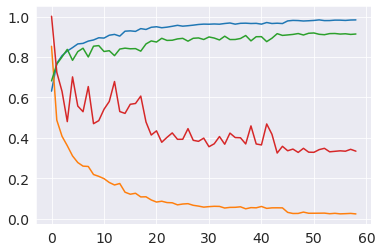

In [54]:
plt.plot(accu)
plt.plot(loss)
plt.plot(val_accu)
plt.plot(val_loss)

Save model

In order to have files < 100MB for github we split the arquitecture and the weights

In [56]:

tl_model.save('/content/drive/My Drive/Hive_Agri/Weeds_fullmodel.h5')


# serialize model to json
json_model = tl_model.to_json()
#save the model architecture to JSON file
with open('/content/drive/My Drive/Hive_Agri/Weeds_arqu.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
tl_model.save_weights('/content/drive/My Drive/Hive_Agri/Weeds_weights.h5')


Loading model from saved files

In [62]:
from keras.models import model_from_json
#Reading the model from JSON file
with open('/content/drive/My Drive/Hive_Agri/Weeds_arqu.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.load_weights('/content/drive/My Drive/Hive_Agri/Weeds_model.h5')
opt=tf.keras.optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
model_j.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [66]:
print(model_j.evaluate(test_image_gen))


110/110 [==============================] - 13s 116ms/step - loss: 0.3134 - accuracy: 0.9126
[0.31338056921958923, 0.9126213788986206]


Model has 81% accuracy with no augmentation, not treating the imbalanced dataset and only training the new layers

After augmentation, class_weights and training a few layers from the resnet50 the model has 90% accuracy

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model_j.predict(test_image_gen)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix


Text(155.0, 0.5, 'True Labels')

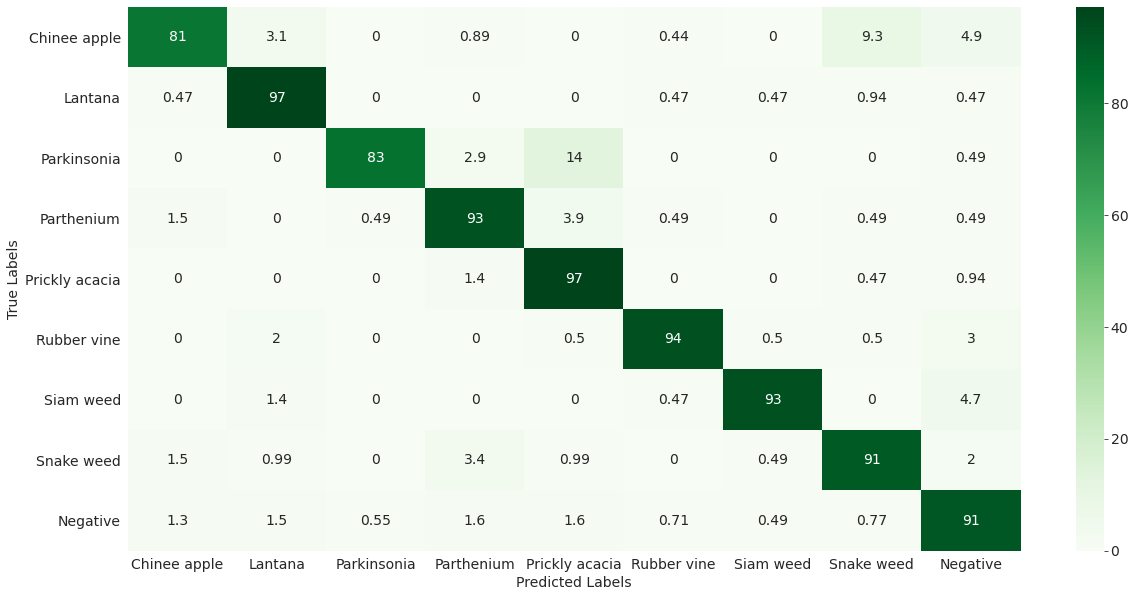

In [69]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_image_gen.classes, y_pred, labels=[0, 1, 3, 4, 5, 6, 7, 8, 2])
mat = ((cf_matrix / cf_matrix.sum(axis=1, keepdims=True) )* 100)
plt.rcParams.update({'font.size': 14})
fig = plt.subplots(figsize = (20, 10))
sns.heatmap(mat, annot=True, cmap='Greens', yticklabels=CLASSES, xticklabels=CLASSES)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

In [59]:
print(num2class)
print(classification_report(test_image_gen.classes, y_pred))

{0: 'Chinee apple', 1: 'Lantana', 2: 'Negative', 3: 'Parkinsonia', 4: 'Parthenium', 5: 'Prickly acacia', 6: 'Rubber vine', 7: 'Siam weed', 8: 'Snake weed'}
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       225
           1       0.84      0.96      0.90       213
           2       0.98      0.91      0.94      1821
           3       0.96      0.83      0.89       206
           4       0.78      0.93      0.85       204
           5       0.74      0.97      0.84       213
           6       0.94      0.94      0.94       202
           7       0.94      0.95      0.95       215
           8       0.81      0.91      0.86       203

    accuracy                           0.91      3502
   macro avg       0.87      0.91      0.89      3502
weighted avg       0.92      0.91      0.91      3502



In [67]:
model_j.save('/content/drive/My Drive/Hive_Agri/Weeds_fullmodel2.h5')